# SWE results: plots for the paper
*Connor Duffin*

In this notebook we generate all the plots for our paper "Exploring Model Misspecification in Shallow Water Equations via Statistical Finite Elements". The basic structure of this notebook is that we read in the data, format it into an `xarray` data structure, then generate a plot. This is done for all the various case studies in the paper, and it roughly follows the ordering of the paper.

If you see anything of interest or have any questions, please do get in touch (cpd32 `at` cam.ac.uk).

## Initialising data and getting things set up

Here we first define some helper functions and the like, to be used later on. We also import libraries and some definitions for the figure sizes:

In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from glob import glob
from tabulate import tabulate

import sys
sys.path.insert(0, "../src")
from figures import figure_sizes, texp

def errors_from_output_file(output_file, prior=False):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    s = checkpoint["/"].attrs["s"]
    nx_obs = checkpoint["/"].attrs["nx_obs"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 2e-3
    
    t_obs = checkpoint["/t_obs"][:]

    # HACK(connor): get analysis to work with misaligned times
    failed_sim = False
    if t_obs[-1] == 0.:
        failed_sim = True
        idx_failed = t_obs > 0
    
    if failed_sim:
        t_obs = t_obs[idx_failed]
        rmse = checkpoint["/rmse"][idx_failed]
    else:
        rmse = checkpoint["/rmse"][:]
        
    # coordinates
    coords = dict(t=t_obs,
                  nu=np.array([nu]),
                  s=np.array([s]),
                  nx_obs=np.array([nx_obs]),
                  nt_skip=np.array([nt_skip]))

    # load in errors etc
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis],
                               coords=coords, name="rmse")
    if not prior:
        if failed_sim:
            lml = checkpoint["/lml"][idx_failed]
        else:
            lml = checkpoint["/lml"][:]

        checkpoint.close()
        lml_ds = xr.DataArray(data=lml[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis],
                              coords=coords, name="lml")
        return xr.merge([rmse_ds, lml_ds])
    else:
        checkpoint.close()
        return xr.merge([rmse_ds])
    
    
def build_output_ds(output_files, prior=False):
    errors_ds = []
    for output_file in output_files:
        e = errors_from_output_file(output_file, prior=prior)
        errors_ds.append(e)

    errors = xr.merge(errors_ds)
    return errors

## Analysis of posteriors: changing observation frequency

First we read in the prior files (linear, nonlinear):

In [2]:
output_files_prior = glob(
    "../outputs/swe-tidal-sparse/nonlinear-prior-*.h5")

output_files_linear_prior = glob(
    "../outputs/swe-tidal-sparse/linear-prior-*.h5")

errors_prior = build_output_ds(output_files_prior, prior=True)
errors_linear_prior = build_output_ds(output_files_linear_prior, 
                                      prior=True)

print(errors_prior)
print(errors_linear_prior)

<xarray.Dataset>
Dimensions:  (t: 1440, nu: 7, s: 5, nx_obs: 3, nt_skip: 1)
Coordinates:
  * t        (t) float64 1.0 31.0 61.0 91.0 ... 4.311e+04 4.314e+04 4.317e+04
  * nu       (nu) float64 1.0 5.0 10.0 500.0 1e+03 1e+04 5e+04
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 30
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02159 0.02127 ... 0.5459
<xarray.Dataset>
Dimensions:  (t: 1440, nu: 7, s: 5, nx_obs: 3, nt_skip: 1)
Coordinates:
  * t        (t) float64 1.0 31.0 61.0 91.0 ... 4.311e+04 4.314e+04 4.317e+04
  * nu       (nu) float64 1.0 5.0 10.0 500.0 1e+03 1e+04 5e+04
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 30
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02159 0.02127 ... 0.5459


Then we read in the posterior files for the fixed `s` case:

In [3]:
output_files_post_fixed_s = glob(
    "../outputs/swe-tidal-sparse/nonlinear-posterior-s-2000.0-*")

errors_post_fixed_s = build_output_ds(output_files_post_fixed_s, prior=False)
print(errors_post_fixed_s)

<xarray.Dataset>
Dimensions:  (t: 43200, nu: 5, s: 1, nx_obs: 3, nt_skip: 5)
Coordinates:
  * t        (t) float64 1.0 2.0 3.0 4.0 ... 4.32e+04 4.32e+04 4.32e+04 4.32e+04
  * nu       (nu) float64 5.0 500.0 1e+03 1e+04 5e+04
  * s        (s) float64 2e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 1 30 60 120 180
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02156 0.02156 ... nan nan
    lml      (t, nu, s, nx_obs, nt_skip) float64 -35.1 -35.1 -35.1 ... nan nan


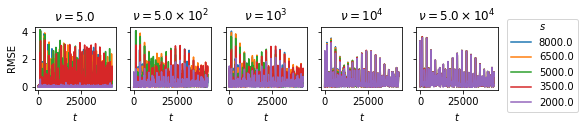

In [4]:
nu_slice = [1, 3, 4, 5, 6]
nus =  errors_prior.coords["nu"].to_numpy()[nu_slice]
nu_labels = [fr"$\nu = {texp(f'{nu:.1e}', False)}$" for nu in nus]
errors_prior = errors_prior.reindex(s=errors_prior.coords["s"][::-1])

p = errors_prior.rmse.isel(
    nx_obs=0, nu=nu_slice).interpolate_na(dim="t").plot(
    hue="s", col="nu",
    figsize=(figure_sizes["fullwidth"], 0.25 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

p.figlegend.set_title(r"$s$")

for i, ax in enumerate(p.axes.flat):
    pass

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])

for ax in p.axes[-1, :]:
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE")
    
p.fig.savefig("../figures/prior-nu-s-rmse.pdf")
plt.show()

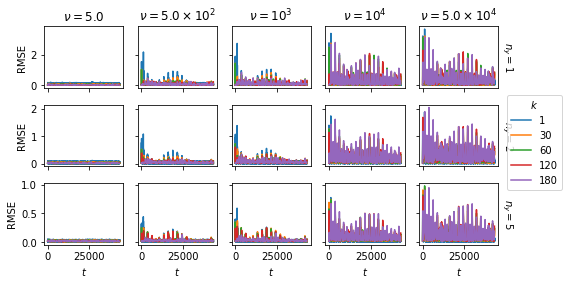

In [5]:
nus =  errors_post_fixed_s.coords["nu"].to_numpy()
nu_labels = [fr"$\nu = {texp(f'{nu:.1e}', False)}$" for nu in nus]

p = errors_post_fixed_s.rmse.isel(s=0).interpolate_na(dim="t").plot(
    hue="nt_skip", col="nu", row="nx_obs",
    figsize=(figure_sizes["fullwidth"], 0.55 * figure_sizes["fullwidth"]),
    sharex=True, sharey="row")

# figure customization
p.figlegend.set_title(r"$k$")
# p.figlegend.remove()

for i, ax in enumerate(p.axes.flat):
    pass
    # ax.set_yscale("log")

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])

for ax in p.axes[-1, :]:
    ax.set_xlabel(r"$t$")

ny_labels = [
    fr"$n_y = {nx_obs}$" for nx_obs in errors_post_fixed_s.coords["nx_obs"].to_numpy()]
for i, ax in enumerate(p.axes[:, -1]):
    plt.setp(ax.texts, text=ny_labels[i]) 
    
for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE")
    
p.fig.savefig("../figures/rmse-post-nu-nt-skip-nx-obs.pdf")
plt.show()

In [6]:
output_files_post_fixed_nu = glob(
    "../outputs/swe-tidal-sparse/nonlinear-posterior-*-nu-5.00e+00-*")

errors_post_fixed_nu = build_output_ds(
    output_files_post_fixed_nu, prior=False)
print(errors_post_fixed_nu)

<xarray.Dataset>
Dimensions:  (t: 43200, nu: 1, s: 5, nx_obs: 3, nt_skip: 5)
Coordinates:
  * t        (t) float64 1.0 2.0 3.0 4.0 ... 4.32e+04 4.32e+04 4.32e+04 4.32e+04
  * nu       (nu) float64 5.0
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 1 30 60 120 180
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02156 0.02156 ... nan nan
    lml      (t, nu, s, nx_obs, nt_skip) float64 -35.1 -35.1 -35.1 ... nan nan


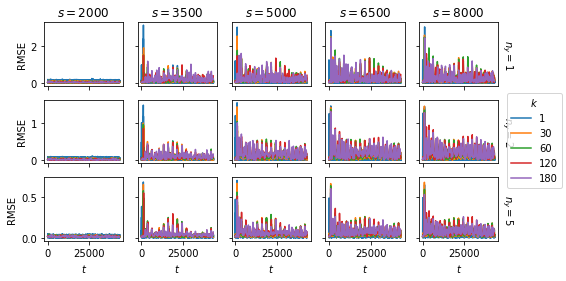

In [7]:
p = errors_post_fixed_nu.rmse.isel(nu=0).interpolate_na(dim="t").plot(
    hue="nt_skip", col="s", row="nx_obs",
    figsize=(figure_sizes["fullwidth"], 0.55 * figure_sizes["fullwidth"]),
    sharex=True, sharey="row")

# figure customization
p.figlegend.set_title(r"$k$")

s_all =  errors_post_fixed_nu.coords["s"].to_numpy()
s_labels = [fr"$s = {s:.0f}$" for s in s_all]
for i, ax in enumerate(p.axes.flat):
    pass
    # ax.set_yscale("log")

for ax in p.axes[-1, :]:
    ax.set_xlabel(r"$t$")

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(s_labels[i])

ny_labels = [fr"$n_y = {nx_obs}$" for nx_obs in errors_post_fixed_nu.coords["nx_obs"].to_numpy()]
for i, ax in enumerate(p.axes[:, -1]):
    plt.setp(ax.texts, text=ny_labels[i]) 
    
for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE") 

p.fig.savefig("../figures/rmse-post-s-nt-skip-nx-obs.pdf")
plt.show()

## Varying the spatiotemporal observation frequency

In [8]:
output_files_post_st = glob(
    "../outputs/swe-tidal-sparse/nonlinear-posterior-s-3500.0-*-nu-5.00e+00*")

errors_post_st = build_output_ds(output_files_post_st, prior=False)
print(errors_post_st)

<xarray.Dataset>
Dimensions:  (t: 43200, nu: 1, s: 1, nx_obs: 3, nt_skip: 5)
Coordinates:
  * t        (t) float64 1.0 2.0 3.0 4.0 ... 4.32e+04 4.32e+04 4.32e+04 4.32e+04
  * nu       (nu) float64 5.0
  * s        (s) float64 3.5e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 1 30 60 120 180
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02156 0.02156 ... nan nan
    lml      (t, nu, s, nx_obs, nt_skip) float64 -35.1 -35.1 -35.1 ... nan nan


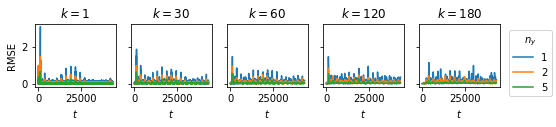

In [9]:
p = errors_post_st.rmse.isel(nu=0, s=0).interpolate_na(dim="t").plot(
    hue="nx_obs", col="nt_skip",
    figsize=(figure_sizes["fullwidth"], 0.25 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

p.figlegend.set_title(r"$n_y$")

k_labels = [fr"$k = {k}$" for k in errors_post_st.coords["nt_skip"].to_numpy()] 
for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(k_labels[i])
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE")
    
p.fig.savefig("../figures/rmse-post-s-misspec-nt-skip-nx-obs.pdf")
plt.show()

In [10]:
mean_rmse = errors_post_st.isel(nu=0, s=0).rmse.mean(dim="t", skipna=True)
sd_rmse = errors_post_st.isel(nu=0, s=0).rmse.std(dim="t", skipna=True)
means = mean_rmse.to_numpy()
sds = sd_rmse.to_numpy()

means_sds_formatted = np.chararray(means.shape, itemsize=32)
n_row, n_col = means.shape

for i in range(n_row):
    for j in range(n_col):
        means_sds_formatted[i, j] = fr"{means[i, j]:.4f} ({sds[i, j]:.3f})"

print(tabulate(means_sds_formatted, 
               mean_rmse["nt_skip"].to_numpy(),
               showindex=mean_rmse.coords["nx_obs"].to_numpy()))

# export table to disk
with open("../figures/s-misspec-rmse-nt-skip-nx-obs.tex", "w") as f:
    f.write(tabulate(means_sds_formatted,
                     mean_rmse["nt_skip"].to_numpy(),
                     showindex=mean_rmse.coords["nx_obs"].to_numpy(),
                     tablefmt="latex_raw"))

    1               30              60              120             180
--  --------------  --------------  --------------  --------------  --------------
 1  0.0543 (0.080)  0.1222 (0.123)  0.1447 (0.128)  0.1792 (0.153)  0.1944 (0.177)
 2  0.0417 (0.048)  0.0720 (0.073)  0.0857 (0.072)  0.1019 (0.080)  0.1127 (0.079)
 5  0.0266 (0.026)  0.0356 (0.040)  0.0389 (0.042)  0.0438 (0.045)  0.0452 (0.027)


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


## Joint parametric misspecification

In [11]:
output_files_post_joint = glob(
    "../outputs/swe-tidal-sparse/nonlinear-posterior-*-nx_obs-1-nt_skip-30-*")

errors_post_joint = build_output_ds(output_files_post_joint, prior=False)
print(errors_post_joint)

<xarray.Dataset>
Dimensions:  (t: 1440, nu: 5, s: 5, nx_obs: 1, nt_skip: 1)
Coordinates:
  * t        (t) float64 1.0 31.0 61.0 91.0 ... 4.311e+04 4.314e+04 4.317e+04
  * nu       (nu) float64 5.0 500.0 1e+03 1e+04 5e+04
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 1
  * nt_skip  (nt_skip) int64 30
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02156 0.02156 ... 0.4673
    lml      (t, nu, s, nx_obs, nt_skip) float64 -35.1 -35.1 ... -1.747e+04


In [12]:
errors_post_array = errors_post_joint.to_array("metric")
errors_post_array = errors_post_array.reindex(s=errors_post_array.coords["s"][::-1])

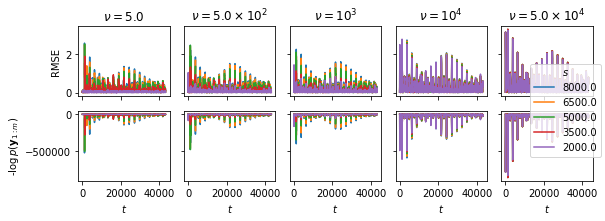

In [13]:
p = errors_post_array.interpolate_na(dim="t").plot(
    x="t", col="nu", hue="s", row="metric",
    figsize=(figure_sizes["fullwidth"], 
             0.4 * figure_sizes["fullwidth"]),
    sharex=True, sharey="row")
p.set_titles("")
plt.tight_layout()

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])
    # ax.set_yscale("log")

for ax in p.axes[1, :]:
    ax.set_xlabel(r"$t$")
    # ax.set_yscale("log")

p.axes[0, 0].set_ylabel("RMSE")
p.axes[1, 0].set_ylabel(r"-$\log p(\mathbf{y}_{1:m})$")

p.figlegend.set_title("$s$")
p.fig.savefig("../figures/nu-s-rmse-nlml-layout.pdf", 
              bbox_inches="tight")
plt.show()

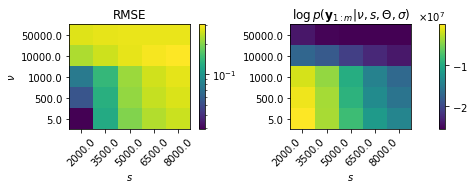

In [14]:
import matplotlib.colors as colors

# mean the RMSEs, sum the LMLs
total_rmse = errors_post_joint.rmse.isel(nt_skip=0, nx_obs=0).mean(dim="t")
total_lml = errors_post_joint.lml.isel(nt_skip=0, nx_obs=0).sum(dim="t")

rmse_array = total_rmse.to_numpy()
lml_array = total_lml.to_numpy()

fig, ax = plt.subplots(1, 2, 
                       figsize=(0.9 * figure_sizes["fullwidth"], 
                                0.35 * figure_sizes["fullwidth"]), 
                       constrained_layout=True, sharey=False)

plt.xticks(rotation=45, ha='right')
im = ax[0].pcolormesh(range(len(total_rmse.coords["s"].to_numpy())), 
                      range(len(total_rmse.coords["nu"].to_numpy())),
                      rmse_array,
                      norm=colors.LogNorm(vmin=rmse_array.min(), 
                                          vmax=rmse_array.max()))
ax[0].set_xticks(range(len(total_rmse.coords["s"].to_numpy())), 
                 total_rmse.coords["s"].to_numpy(),
                 rotation=45)
ax[0].set_yticks(range(len(total_rmse.coords["nu"].to_numpy())), 
                 total_rmse.coords["nu"].to_numpy())
ax[0].set_xlabel(r"$s$")
ax[0].set_ylabel(r"$\nu$")
ax[0].set_title("RMSE")
cbar = plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(range(len(total_lml.coords["s"].to_numpy())), 
                      range(len(total_lml.coords["nu"].to_numpy())),
                      lml_array)
ax[1].set_xticks(range(len(total_lml.coords["s"].to_numpy())), 
                 total_lml.coords["s"].to_numpy(),
                 rotation=45)
ax[1].set_yticks(range(len(total_lml.coords["nu"].to_numpy())), 
                 total_lml.coords["nu"].to_numpy())
ax[1].set_xlabel(r"$s$")
ax[1].set_title(r"$\log p(\mathbf{y}_{1:m} | \nu, s, \Theta, \sigma)$")

cbar = plt.colorbar(im, ax=ax[1])
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

plt.savefig("../figures/nu-s-rmse-lml-table-color.pdf", dpi=600)

In [15]:
def format_col(col):
    loc = col.argmax()
    out = col.astype(str)
    
    for i in range(len(col)):
        num = texp(f"{col[i]:.3e}", dollar_surround=False)

        if i == loc:
            out[i] = fr"$\mathbf{{{num}}}$"
        else:
            out[i] = fr"${num}$"

    return np.array(out)
        
# check that dimensions are OK
assert total_lml.dims[0] == "nu" and total_lml.dims[1] == "s"

print(tabulate(lml_array, 
               headers=total_lml.coords['s'].to_numpy(),
               showindex=total_lml.coords['nu'].to_numpy()))

lml_formatted = np.apply_along_axis(format_col, 0, lml_array)
with open("../figures/nu-s-lml-table.tex", "w") as f:
    f.write(tabulate(lml_formatted,
                     headers=total_lml.coords['s'].to_numpy(),  # columns
                     showindex=total_lml.coords['nu'].to_numpy(),  # rows
                     tablefmt="latex_raw"))

                  2000.0        3500.0        5000.0        6500.0        8000.0
-----  -----------------  ------------  ------------  ------------  ------------
    5  -154083            -3.45318e+06  -8.17388e+06  -1.18041e+07  -1.40575e+07
  500  -818434            -3.59864e+06  -9.21578e+06  -1.34599e+07  -1.58226e+07
 1000       -1.79505e+06  -4.24852e+06  -9.86573e+06  -1.44086e+07  -1.70067e+07
10000       -1.73611e+07  -1.855e+07    -2.09129e+07  -2.28446e+07  -2.40278e+07
50000       -2.40935e+07  -2.54111e+07  -2.56227e+07  -2.56386e+07  -2.56402e+07


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


## Linear model mismatch

In [16]:
output_files_post_linear = glob(
    "../outputs/swe-tidal-sparse/linear-posterior-*-nx_obs-1-*")

errors_linear_post = build_output_ds(output_files_post_linear, prior=False)
errors_linear_post = errors_linear_post.reindex(s=errors_linear_post.coords["s"][::-1])
print(errors_linear_post)

<xarray.Dataset>
Dimensions:  (t: 43200, nu: 7, s: 5, nx_obs: 1, nt_skip: 5)
Coordinates:
  * t        (t) float64 1.0 2.0 3.0 4.0 ... 4.32e+04 4.32e+04 4.32e+04 4.32e+04
  * nu       (nu) float64 1.0 5.0 10.0 500.0 1e+03 1e+04 5e+04
  * s        (s) float64 8e+03 6.5e+03 5e+03 3.5e+03 2e+03
  * nx_obs   (nx_obs) int64 1
  * nt_skip  (nt_skip) int64 1 30 60 120 180
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02156 0.02156 ... nan nan
    lml      (t, nu, s, nx_obs, nt_skip) float64 -35.1 -35.1 -35.1 ... nan nan


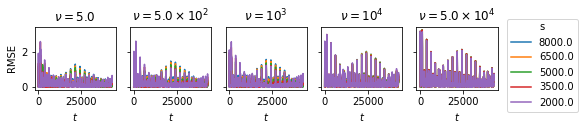

In [17]:
nu_slice = [1, 3, 4, 5, 6]
p = errors_linear_post.rmse.isel(nx_obs=0, nt_skip=1, nu=nu_slice).interpolate_na(dim="t").plot(
    col="nu", hue="s",
    figsize=(figure_sizes["fullwidth"], 
             0.25 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE")
p.fig.savefig("../figures/linear-nu-s-rmse.pdf", 
              bbox_inches="tight")

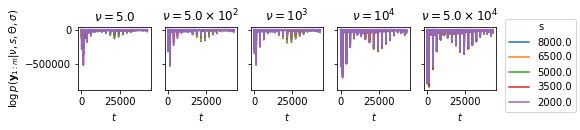

In [18]:
p = errors_linear_post.lml.isel(nx_obs=0, nt_skip=1, nu=nu_slice).interpolate_na(dim="t").plot(
    col="nu", hue="s",
    figsize=(figure_sizes["fullwidth"], 
             0.25 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])
    ax.set_xlabel(r"$t$")
    # ax.set_yscale("log")

for ax in p.axes[:, 0]:
    ax.set_ylabel(r"$\log p(\mathbf{y}_{1:m} | \nu, s, \Theta, \sigma)$")
plt.show()

In [19]:
# re-order to have ascending
errors_linear_post = errors_linear_post.reindex(s=errors_linear_post.coords["s"][::-1])

ave_rmse = errors_linear_post.isel(nx_obs=0, nt_skip=1).rmse.mean(dim="t", skipna=True)
assert ave_rmse.dims[0] == "nu" and ave_rmse.dims[1] == "s"
ave_rmse_numpy = ave_rmse.to_numpy()

print(tabulate(ave_rmse_numpy, 
               headers=ave_rmse.coords["s"].to_numpy(),  # columns
               showindex=ave_rmse["nu"].to_numpy()))  # rows

lml_total = errors_linear_post.isel(nx_obs=0, nt_skip=1, nu=nu_slice).lml.sum(dim="t")

# check that dimensions are OK
assert lml_total.dims[0] == "nu" and lml_total.dims[1] == "s"

lml_total_numpy = lml_total.to_numpy()
lml_formatted = np.apply_along_axis(format_col, 0, lml_total_numpy)
with open("../figures/linear-nu-s-lml-table.tex", "w") as f:
    f.write(tabulate(lml_formatted,
                     headers=lml_total.coords["s"].to_numpy(),  # columns
                     showindex=lml_total.coords["nu"].to_numpy(),  # rows
                     tablefmt="latex_raw"))

         2000.0    3500.0    5000.0    6500.0    8000.0
-----  --------  --------  --------  --------  --------
    1  0.16077   0.14704   0.164538  0.182328  0.205932
    5  0.160783  0.147055  0.164641  0.182498  0.206084
   10  0.160809  0.14708   0.16477   0.182735  0.206269
  500  0.166981  0.153662  0.173432  0.196782  0.219148
 1000  0.169699  0.157834  0.177728  0.202772  0.224611
10000  0.229144  0.226471  0.239307  0.250978  0.258022
50000  0.259082  0.266938  0.268208  0.267975  0.267746


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:
/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:
